In [11]:
import skimage as ski
from skimage import color,io,filters,measure
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [12]:
%matplotlib inline

In [13]:
numberOfImgs = 4
def show(imgs,CMAP = None):
    cols = 2
    rows = 2
    fig, ax = plt.subplots(rows,cols ,figsize = (10,10),constrained_layout=True)
    fig.set_constrained_layout_pads(w_pad=0.02, h_pad=0.02,
            hspace=0., wspace=0.)
    [axi.set_axis_off() for axi in ax.ravel()]
    for i in range(rows):
        for j in range(cols):
            ax[i][j].imshow(imgs[i*cols+j],CMAP)

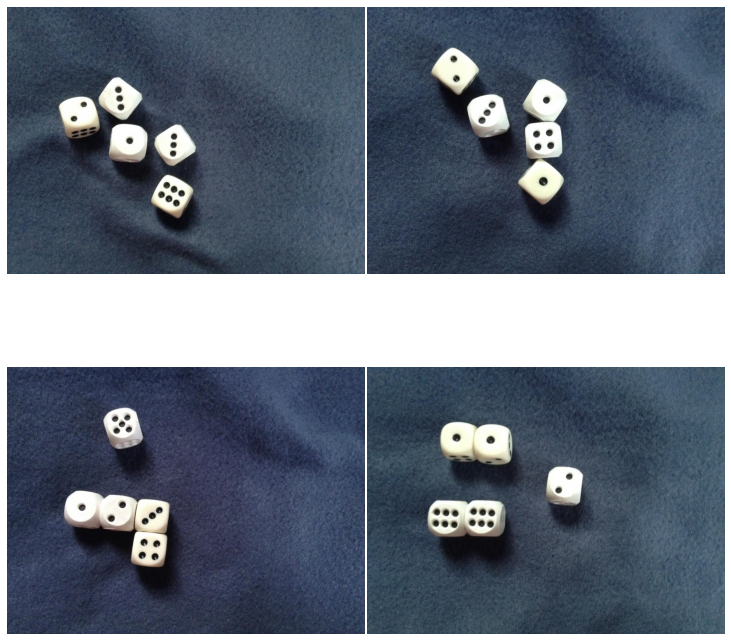

In [14]:
img = [io.imread(str(30+i)+".jpg") for i in range(numberOfImgs)]
#img = color.rgba2rgb(img)
#img = ski.img_as_ubyte(img)
show(img)

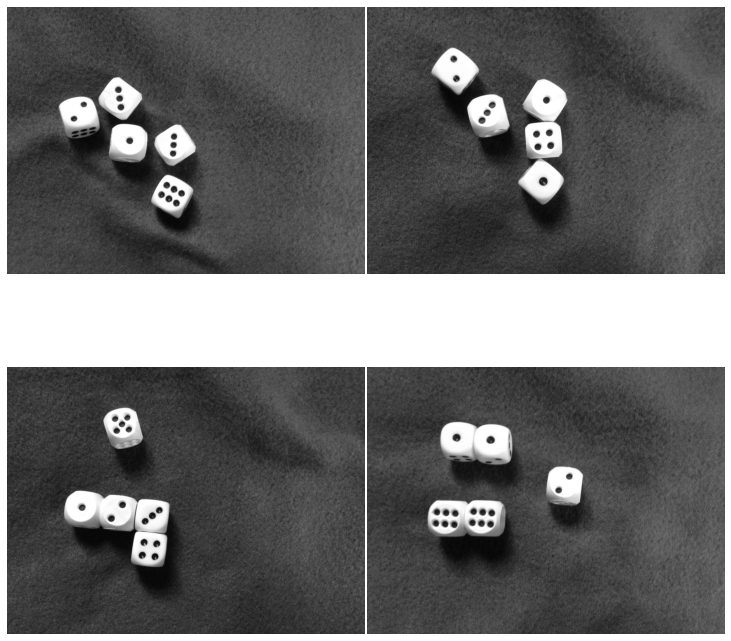

In [15]:

imgG = [color.rgb2gray(i) for i in img]
#imgG = color.rgb2hsv(img)[:,:,2]
show(imgG,"gray")

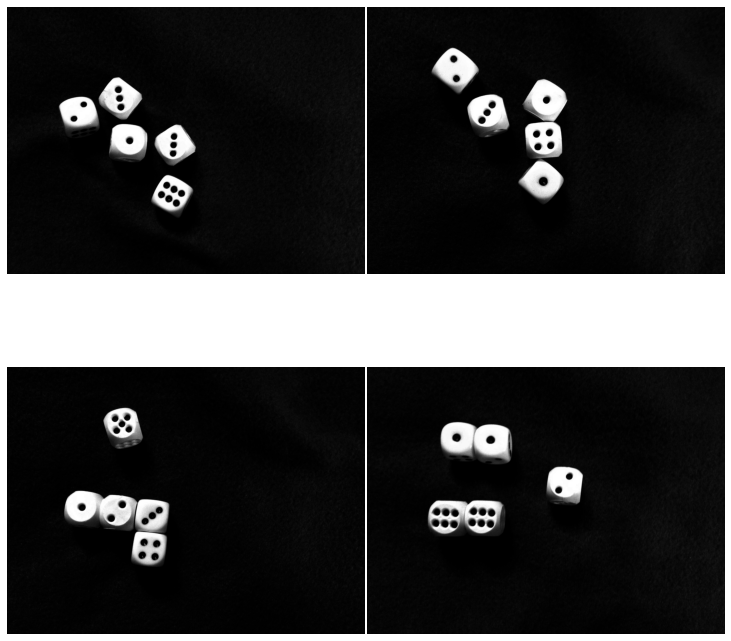

In [16]:
imgC = [i**3 for i in imgG]
show(imgC,"gray")

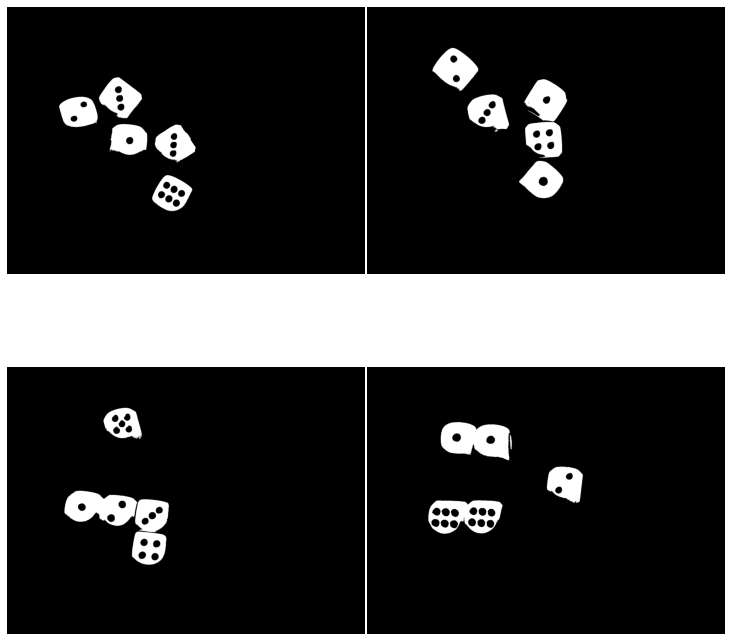

In [17]:
def MakeThresholded(img):
    threshold = filters.threshold_otsu(img)
    imgN = img > threshold
    imgN = ski.morphology.remove_small_objects(imgN)
    #imgT = ski.morphology.binary_erosion(imgT)
    #imgT = ski.morphology.binary_dilation(imgT)
    #imgT = ski.morphology.binary_dilation(imgT)
    return imgN
imgT = [MakeThresholded(i) for i in imgC]
show(imgT,"gray")

5
6
4
4


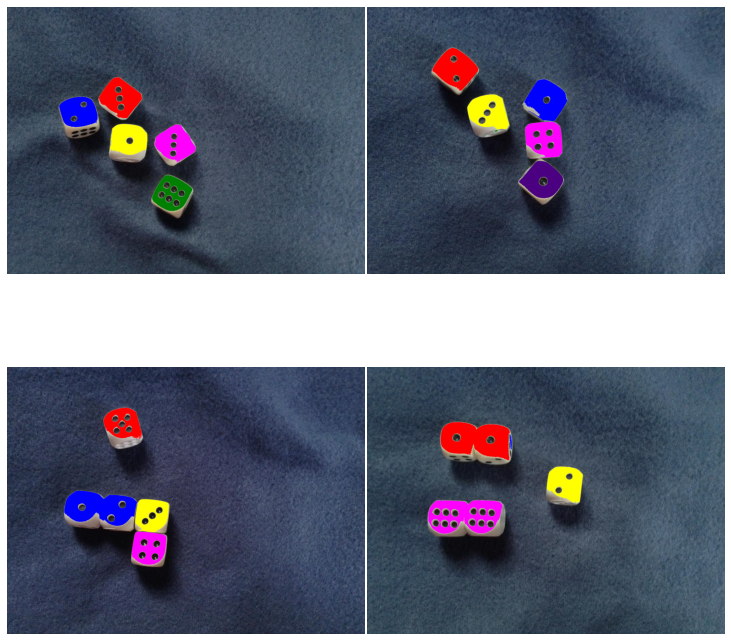

In [18]:
def MakeRegions(imgPom):
    labelImg , n = measure.label(imgPom,return_num = True,connectivity = 2)
    print(n)
    return(labelImg , n)

imgLn = [MakeRegions(i) for i in imgT]

def ShowRegions(i):
    labels = ski.img_as_ubyte(color.label2rgb(imgLn[i][0], bg_label=0))
    regions = measure.regionprops(imgLn[i][0])
    imgTemp = img[i]
    imgTemp[imgLn[i][0] > 0] = labels[imgLn[i][0] > 0]
    return imgTemp 
    
temp  = [ShowRegions(i) for i in range(numberOfImgs)]

show(temp)


3
2
1
3
6
2
1
3
4
1
5
3
4
2


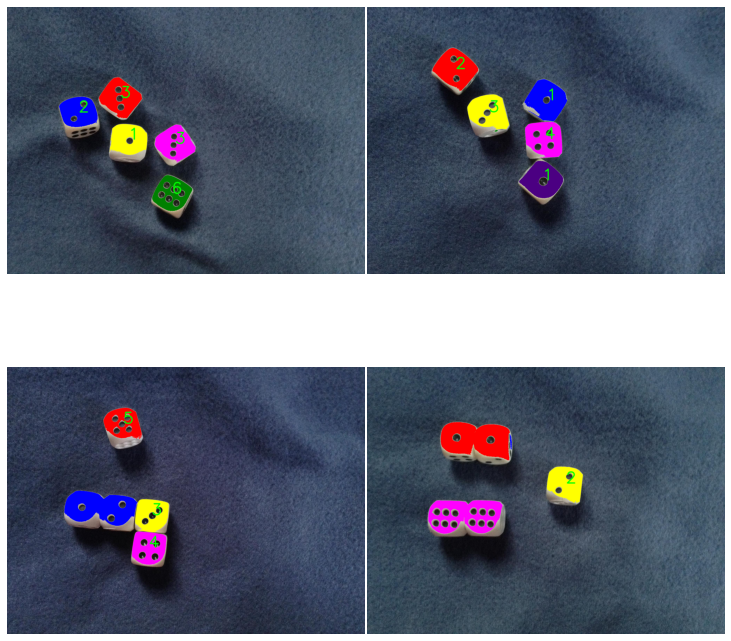

In [19]:
font = cv2.FONT_HERSHEY_SIMPLEX
def ReadDie(labelImg , N , j):
    regions = measure.regionprops(labelImg)
    areasOfRegions = [r.area for r in regions]
    medianOfRegionsArea = np.median(areasOfRegions)
    imgToRead = img[j]
    for i in range(1,N+1):
        if(regions[i-1].area < 1.2 *  medianOfRegionsArea):
            imgPom = (labelImg == i)
            neigh = np.ones((12,12))
            imgPom = ski.morphology.binary_dilation(imgPom,neigh)
            #imgPom = ski.morphology.binary_dilation(imgPom)
            #io.imshow(imgPom,cmap="gray")


            imgPom = 1-imgPom
            x, n = measure.label(imgPom,return_num = True,connectivity = 2)
            if(n>1):
                print(n-1)

                y=int(regions[i-1].centroid[0])
                x=int(regions[i-1].centroid[1])
                cv2.putText(imgToRead, str(n-1), (x,y), font, 3, (0, 255, 0), 5, cv2.LINE_AA)
        
    return imgToRead
        
imgRead = [ReadDie(imgLn[i][0] , imgLn[i][1] , i) for i in range(numberOfImgs)]        
show(imgRead)        

    